## SOM理论
SOM是一种无监督的人工神经网络。不同于一般神经网络基于损失函数的反向传递来训练，它运用竞争学习(competitive learning)策略,依靠神经元之间互相竞争逐步优化网络。且使用近邻关系函数(neighborhood function)来维持输入空间的拓扑结构。

竞争层最少节点数量=$5\sqrt N$   
N: 训练样本的个数   
>如果是正方形输出层,边长等于竞争层节点数再开一次根号,并向上取整就行  

* 第一步: 与其他神经网络相同,需要将Weighs初始化为很小的随机数
* 第二步: 随机取一个 输入样本$x_i$
* 第三步:   
1.遍历竞争层中每一个节点:计算$x_i$与节点之间的相似度(通常使用欧式距离)  
2.选取距离最小的节点作为**优胜节点**(winner node),有时也叫做BMU(best matching unit)

* 第四步: 根据领域半径$\sigma$确定**优胜领域**将包含的节点;并通过neighborhood function计算它们各自更新的幅度(基本思想是:越靠近优胜节点,更新幅度越大;越远离优胜节点,更新幅度越小)
* 第五步: 更新优胜领域内节点的Weight:
$$W_v(s+1)=W_v(s)+\theta(u,v,s)\cdot\alpha(s)\cdot(D(t)-W_v(s))$$
> $\theta(u,v,s)$是对更新的约束,基于离BMU的距离,即neighborhood function的返回值
$W_v(s)$是节点v当前的Wight

* 第六步: 完成一轮迭代(迭代次数+1),返回第二步,直到满足设定的迭代次数

优胜节点更新后会更靠近输入样本Xi在空间中的位置。优胜节点拓扑上的邻近节点也类似地被更新。这就是SOM网络的竞争调节策略。

### neighborhood function
neighborhood函数用来确定**优胜节点对其近邻节点的影响强弱**,即优胜领域中每个节点的更新幅度.最常见的选择是高斯函数,它可以表征优胜领域内,影响强弱与距离的关系.
```
g = neighborhood_func(winner, sigma)
w_new = learning_rate * g * (x-w)
```
* winner是优胜节点在输出平面的坐标
* sigma确定邻域范围,sig越大,领域范围越大
* sigma的取值范围: sigma必须大于0,否则没有神经元会被更新;且sigma不能大于2维输出平面的边长

### SOM特点:
**sigma的有效取值是离散的**：  

0.5：仅优胜节点  

1.5：周围一圈  

2.5：周围2圈  

**学习率α、邻域范围σ随时间衰减**

SOM网络的另一个特点是，学习率和邻域范围随着迭代次数会逐渐衰减  

### 数据预处理
由于SOM是基于距离的算法，所以输入矩阵X中的类别型特征必须进行One-Hot编码

可以考虑进行标准化(均值为0，标准差为1)；这样有助于使每个特征对于计算相似度的贡献相同

三种初始化方法：

* Random initialization：适用于对输入数据有很少或没有任何先验知识
* Initialization using initial samples：优点是初始时刻，网络节点就与输入数据的拓扑结构很相似
* Linear initialization(PCA)：让网络向输入数据能力最大的方向延伸

其实在miniSom创建模型后，就已经进行Random initialization了；som.random_weights_init()其实是"Initialization using initial samples"

### 可视化
SOM本质是在逼近输入数据的概率密度，以下几种工具能非常好的可视化训练好的SOM网络
1. U-Matrix    
通常使用Heatmap来可视化U-matrix，且用颜色编码(数值越大，颜色越深)  
2. Component Plane  
通过component plane，能够可视化相关变量或者额外变量)的分布    
Component plane可以理解成SOM网络的切片版本。每一个component plane包含了一个输入特征的相对分布。  
在这种图中，深色表示相对小的取值，浅色表示相对大的取值。  
通过比较component planes，我们可以看出两个component的相关信。如果看上去类似，那么它们强相关.    

## SOM案例
### 库和数据准备
先导入需要用到的库:  

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math

导入数据集,Iris是一个网上公开的数据集，包含150个数据样本，分为3类鸢尾花，每类50个数据，每个样本包含4个属性(特征)。

In [8]:
iris = datasets.load_iris()
print('>> shape of data:',iris.data.shape)

feature_names = iris.feature_names
class_names = iris.target_names

X = iris.data
y = iris.target

#划分训练集、测试集  7:3
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
#是随机数的种子,种子不同产生的随机数不同
y

>> shape of data: (150, 4)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### 训练模型
选择miniSom库来训练模型

In [21]:
from minisom import MiniSom

N = X_train.shape[0] #样本数量
M = X_train.shape[1] #维度/特征数量


#设置超参数

size = math.ceil(np.sqrt(5*np.sqrt(N))) #经验公式:决定输出层尺寸
print("训练样本个数:{} 测试样本个数:{}".format(N,X_test.shape[0]))
print("输出网格最佳边长为:",size)

max_iter = 200

# 初始 and 训练
som = MiniSom(size, size, M, sigma=3, learning_rate=0.5, neighborhood_function='bubble')
# Neighborhood_function可选的设置有'gaussian'、'mexican_hat'、'bubble'. 调参的时候可以都试一遍，看效果
# 学习率：先设为默认的0.5，大部分情况下都适用

训练样本个数:105 测试样本个数:45
输出网格最佳边长为: 8


初始化权重

In [22]:
#初始化权值，有2个API
#som.random_weights_init(X_train)
som.pca_weights_init(X_train)
# 一般优先考虑pca_weights_init和random_weights_init，其中pca初始化的结果时固定的，
# 也就是说网络初始状态是固定的，而random_weights_init带有一定随机性

In [23]:
som.train_batch(X_train, max_iter, verbose=False)
#som.train_random(X_train, max_iter, verbose=False)
#train_random 每轮迭代随机挑选一个样本来更新权重，直到迭代次数满足max_iter
#train_batch 每次按顺序取一个样本，用过最后一个样本后跳回第一个样本，循环直到迭代次数满足max_iter


分类  
训练时我们只需传入X_train，因为Som是无监督学习算法，不需要标签信息,如果有额外的标签信息，也可以用上，帮助理解训练好的SOM网络

In [24]:
winmap = som.labels_map(X_train,y_train)
#labels_map利用标签信息，标注训练好的Som网络

Som网络一大特点就是保留输入空间中的拓扑结构，那么输入空间中邻近的样本数据会落到相邻的神经元中。我们计算每一个输入样本对应的优胜节点的位置，即输出平面中哪一个神经元计算完所有的训练样本后，我们统计平面中每个神经元的类别个数(这里就用到了标签信息)，例如 某神经元有5个样本能激活它，其中4个属于A类 1个属于B类.简单的方法，我们可以取频率最高的类别，作为该神经元的类别标签；或许，你也可以用各个类的频率估计概率密度.

当新的样本(unseen data)落入输出平面的某个神经元时，我们就可以判断样本的类别了！

In [25]:
def classify(som,data,winmap):
    from numpy import sum as npsum
    default_class = npsum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

训练出来的模型在测试集上的效果

In [26]:
# 输出混淆矩阵
y_pred = classify(som,X_test,winmap)
print(classification_report(y_test, np.array(y_pred)))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       0.93      0.78      0.85        18
           2       0.59      0.91      0.71        11

    accuracy                           0.82        45
   macro avg       0.84      0.83      0.82        45
weighted avg       0.87      0.82      0.83        45



可视化  
根据权重矩阵W,可以计算每个神经元距离它的邻近神经元们的距离,计算好的矩阵就是U-Matrix

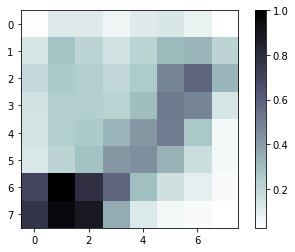

In [27]:
heatmap = som.distance_map()  #生成U-Matrix
plt.imshow(heatmap, cmap='bone_r')      #miniSom案例中用的pcolor函数,需要调整坐标
plt.colorbar()

在输出层画标签图案

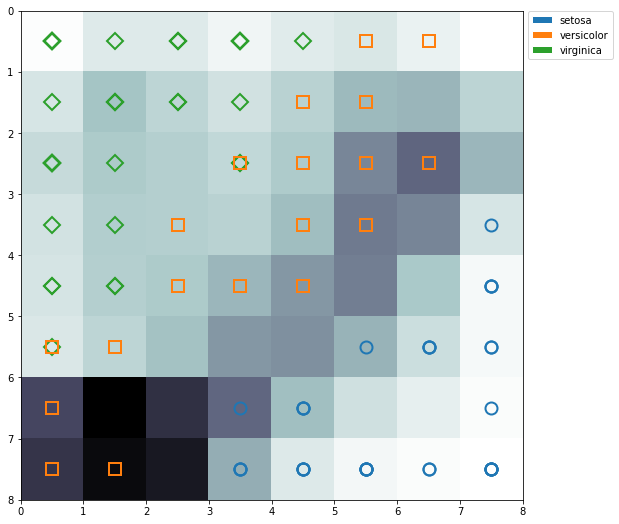

In [28]:
plt.figure(figsize=(9, 9))
# 背景上画U-Matrix
heatmap = som.distance_map()
plt.pcolor(heatmap, cmap='bone_r')  # plotting the distance map as background

# 定义不同标签的图案标记
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
category_color = {'setosa': 'C0',
                  'versicolor': 'C1',
                  'virginica': 'C2'}
for cnt, xx in enumerate(X_train):
    w = som.winner(xx)  # getting the winner
    # 在样本Heat的地方画上标记
    plt.plot(w[0]+.5, w[1]+.5, markers[y_train[cnt]], markerfacecolor='None',
             markeredgecolor=colors[y_train[cnt]], markersize=12, markeredgewidth=2)
plt.axis([0, size, 0, size])
ax = plt.gca()
#颠倒y轴方向
ax.invert_yaxis()
#画图例
legend_elements = [Patch(facecolor=clr,
                         edgecolor='w',
                         label=l) for l, clr in category_color.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, .95))
plt.show()

三种类别的样本落在了输出平面上的不同位置，并且这条分界线大致将 蓝色样本 与橙色、绿色样本划分开了  
画饼图  


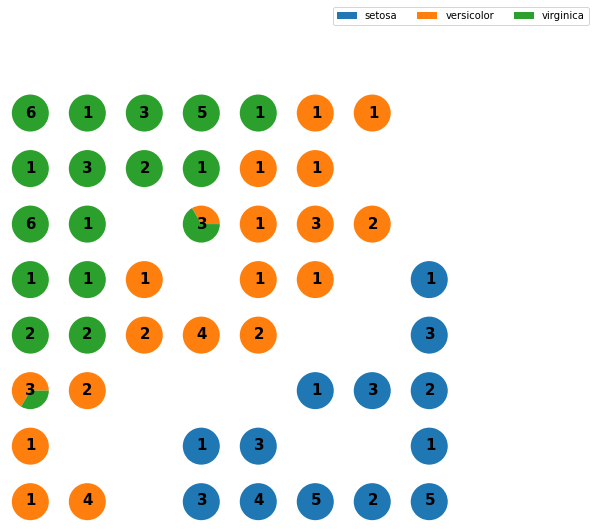

In [34]:
label_name_map_number = {"setosa":0,"versicolor":1,"virginica":2}

from matplotlib.gridspec import GridSpec
plt.figure(figsize=(8, 8))
the_grid = GridSpec(size, size)
for position in winmap.keys():
    label_fracs = [winmap[position][label] for label in [0,1,2]]
    plt.subplot(the_grid[position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
    plt.text(position[0]/100, position[1]/100,  str(len(list(winmap[position].elements()))),
              color='black', fontdict={'weight': 'bold',  'size': 15},
              va='center',ha='center')
plt.legend(patches, class_names, loc='center left', bbox_to_anchor=(2, 5), ncol=3)
plt.show()

Component Plane  
Component Plane每个神经元对单个特征什么取值最敏感